# Inverse Distance Weighting (IDW)

The IDW is a deterministic method that predicts values at unsampled locations based on a set of locations at which the values are known. IDW assesses similiarity of values at locations based on an inverse measurement of proximity. That is, closer observed values will have a greater impact on the estimation at a location than further values.

In [1]:
inLibraries = list('repr','rgdal','gstat','sp','spdep','rgeos','maptools','RColorBrewer','classInt','raster')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

## Read Observed Measurements

In this practice, the primary goal is to obtain a good estimate of maximum temperature for locations in Missouri. While observations of temperature from locations solely within the state could be used, it is much better to also include observations from surrounding states as well in order to avoid edge effects. As such, we will use observations of maximum temperature at 245 weather stations within the state of Missouri and its eight surroundings states (KY,AR,IA,IL,KS,NE,OK,TN) to infer maximum temperature at locations having no weather station.  

The station point locations can be found at (weatherdata/weather_data_points.shp) and state boundaries that can be used for spatial context can be found at (weatherdata/states_polygon.shp). The maximum temperature attribute in the station dataset is named 'highTemp' and was derived from a single day's weather information obtained from https://www.wunderground.com/. 

In [2]:
# Read point data of weather station locations
inFeature.pts <- readOGR("/dsa/data/geospatial/DS8612/weatherdata","weatherdatapoints")

# Read polygon data of states boundaries
inFeature.polys <- readOGR("/dsa/data/geospatial/DS8612/weatherdata","states_polygon")

# Define new variable for interpolation
inVa <- as.numeric (inFeature.pts$highTemp)

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/weatherdata", layer: "weatherdatapoints"
with 230 features
It has 17 fields
OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/weatherdata", layer: "states_polygon"
with 9 features
It has 9 fields


In [4]:
head(inFeature.pts@data)

state,city,day,month,year,period,highTemp,lowTemp,conditions,qpf_allday,snow_allda,avewindSpe,avewindDir,avewindDeg,avehumidit,Longi,Lati
IA,Chariton,13,7,2017,1,82,61,Partly Cloudy,0,0,0,West,272,81,-93.31,41.01
OK,Chickasha,13,7,2017,1,100,73,Clear,0,0,0,SSW,211,69,-97.95,35.04
IL,Lacon,13,7,2017,1,84,62,Partly Cloudy,0,0,4,West,0,89,-89.41,41.02
IA,Clarion,13,7,2017,1,77,55,Partly Cloudy,0,0,7,NNW,0,86,-93.73,42.72
AR,De Queen,13,7,2017,1,98,73,Partly Cloudy,0,0,1,SW,224,92,-94.34,34.04
TN,Memphis,13,7,2017,1,92,75,Partly Cloudy,0,0,5,SSW,204,81,-90.05,35.15


In [5]:
head(inFeature.polys@data)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER
0,20,00481813,0400000US20,20,KS,Kansas,00,211753253104,1346235678
1,29,01779791,0400000US29,29,MO,Missouri,00,178052653610,2487575477
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177663722167,3373836066
3,05,00068085,0400000US05,05,AR,Arkansas,00,134771517596,2960191698
4,17,01779784,0400000US17,17,IL,Illinois,00,143788697679,6206693598
5,19,01779785,0400000US19,19,IA,Iowa,00,144667643793,1077808017


## Sync CRS of Point and Polygon Featureclasses

If you look at the two input datasets, you'll find that they are in two different CRSs. As such, if we wish to compare or overlay these geographies, then they will need to be in the same CRS. The point data are in UTM zone 15N...let's use that CRS. Now, convert the polygon featureclass into the same CRS as the point featureclass.

In [7]:
#Get CRS of the point featureclass
ptCRS <- proj4string (inFeature.pts)

ptCRS

[1] "+proj=utm +zone=15 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0"

In [8]:
# Transform to angular system (lat/long)
inFeature.polys.UTM <- spTransform(inFeature.polys, CRS(ptCRS))

In [9]:
proj4string(inFeature.polys.UTM)

[1] "+proj=utm +zone=15 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0"

## Visualize the Observed Data Points

Classify the observed temperatures into 6 categories and plot the points to examine the spatial distribution of the weather data.

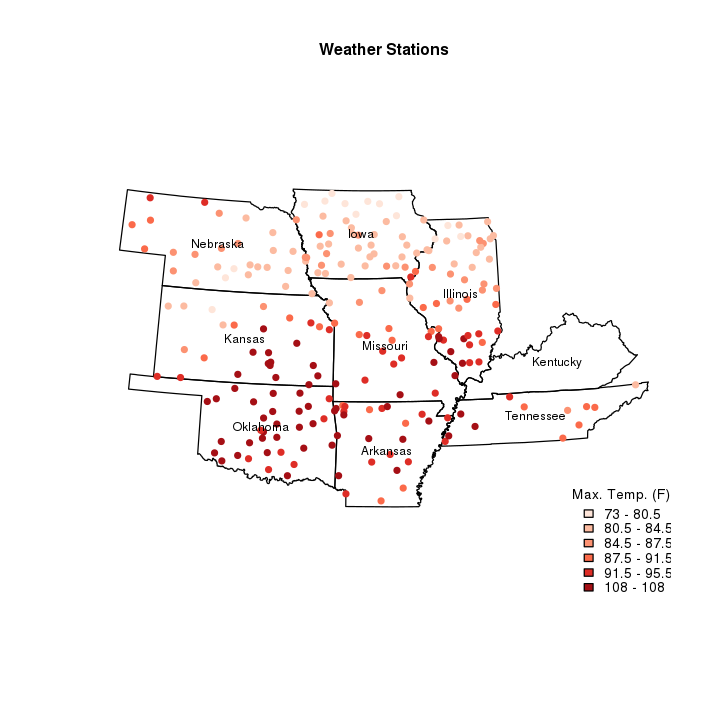

In [10]:
#Configure classification parameters
numcat <- 6
cate <- classIntervals(inVa, numcat, style="kmeans")

#assign colors to categories
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

# Map input data
plot(inFeature.polys.UTM,main="Weather Stations",cex.main=.8)
plot(inFeature.pts,col=cols, pch=20,add=TRUE)

# Get centroid of polygons
centroids <- gCentroid(inFeature.polys.UTM, byid=TRUE)
centroidLons <- coordinates(centroids)[,1]
centroidLats <- coordinates(centroids)[,2]

# Label the name of polygons
text(centroidLons, centroidLats, labels=inFeature.polys.UTM$NAME,cex=0.6)

#map classification scheme
decimalPlaces <- 3
brks.dec <- round(cate$brks,decimalPlaces)
leg.text <- paste(brks.dec[-numcat], brks.dec[-1], sep=" - ")
legend("bottomright",fill=attr(cols,"palette"),legend=leg.text,bty="n",title="Max. Temp. (F)",cex=.7)

## Interpolation Grid Dataframe

The idw() function (gstat library) requires a grid dataframe representing the locations to be interpolated. In order to create a dataframe that covers the study area, the extent of data should be specified. Also, the coordinate reference system needs to be the same as that of the input data. There are several ways to accomplish this task. Here, the expand.grid() function will be called to generate a systematically spaced grid by specifying the 'cellsize' in the units of the coordinate reference system (meters in this case).

In [13]:
#retrieve the extent of the study area
minlon = min (coordinates(inFeature.pts)[,1])
maxlon = max (coordinates(inFeature.pts)[,1])
maxlat = max (coordinates(inFeature.pts)[,2])
minlat = min (coordinates(inFeature.pts)[,2])

In [14]:
minlon

[1] -384202.2

In [16]:
maxlon

[1] 1469780

In [17]:
maxlat

[1] 4806862

In [18]:
minlat

[1] 3674622

In [19]:
long.range <- as.numeric(c(minlon, maxlon))  

long.range

[1] -384202.2 1469779.7

In [20]:
lat.range <- as.numeric(c(minlat, maxlat)) 

lat.range

[1] 3674622 4806862

In [27]:
#set cellsize of interpolation grid
cellsize <- 10000

#create gridded area
grd <- expand.grid(x = seq(
                            from = long.range[1], 
                            to = long.range[2], 
                            by = cellsize), 
                   y = seq(
                            from = lat.range[1], 
                            to = lat.range[2], 
                            by = cellsize)) 

grd[1:5, ]

x,y
-384202.2,3674622
-374202.2,3674622
-364202.2,3674622
-354202.2,3674622
-344202.2,3674622


In [28]:
#assign coordinates to grid
coordinates(grd) <- ~x + y

In [34]:
# condition grid object
gridded(grd) <- TRUE

gridded(grd)

[1] TRUE

In [33]:
# set the projection system to be that of original dataset
proj4string(grd) <- proj4string(inFeature.pts)

proj4string(grd)

[1] "+proj=utm +zone=15 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0"

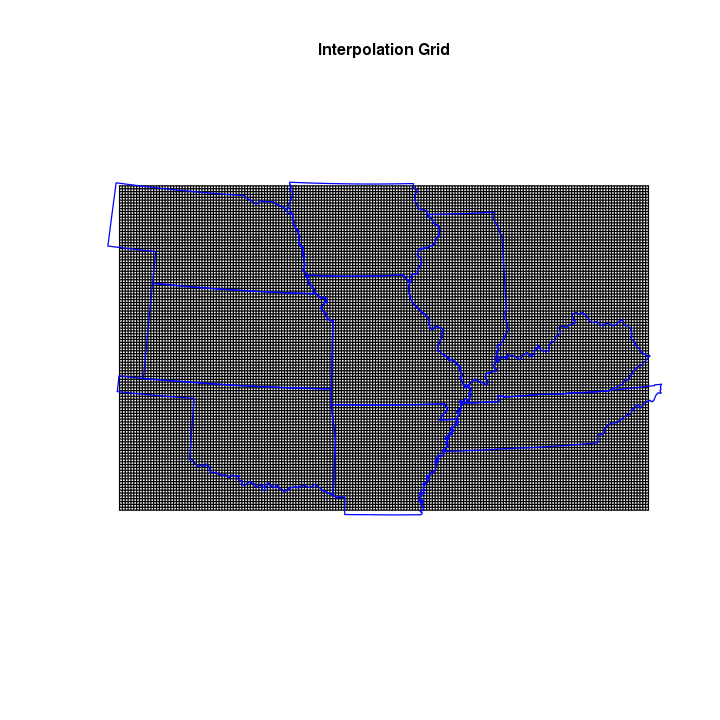

In [32]:
# visualize the grid dataframe
plot (grd, main="Interpolation Grid", cex.main=.8)
plot(inFeature.polys.UTM, border='blue', add=TRUE)

## Conduct IDW

The idw() function (gstat library) is actually a part of the more general krige() functions. 

The function requires a formula involving  

* the dependent variable, 

* location of observed values 

* and a grid object that contains the cells for whose values will be interpolated. 

Other optional arguments that could be adjusted are the minimum (nmin) and maximum (nmax) number of neighboring observations that are considered for interpolation as well how the power weighting is applied to the inverse distance.

### IDW  - Interpolation at Each Cell Involves all Observed Data Points

First, consider the case where interpolation at a location (cell) involves the values at all observed locations. The idp parameter allows modification of the power function (see documentation of the idw() function to learn more). Experiment with the idp parameter and note the effects of its increase/decrease.

In this example, the spplot() function (sp library) is used to display the interpolated raster. The spplot() function is a useful extension of the plot() function we've been using. It allows for more integrated plotting functionality of spatial datasets.

In [38]:
# implement global idw (all observations)
temidw1 <- idw(formula = inVa ~ 1, 
                   locations = inFeature.pts, 
                   newdata = grd,
                   idp = 0.5)

names(temidw1)

[inverse distance weighted interpolation]


[1] "var1.pred" "var1.var"

In [41]:
#retrieve the interpolated files from the gridded spatialpixels dataframe
rvals <- temidw1@data$var1.pred

rvals[1:5]

[1] 90.38262 90.39399 90.40557 90.41738 90.42941

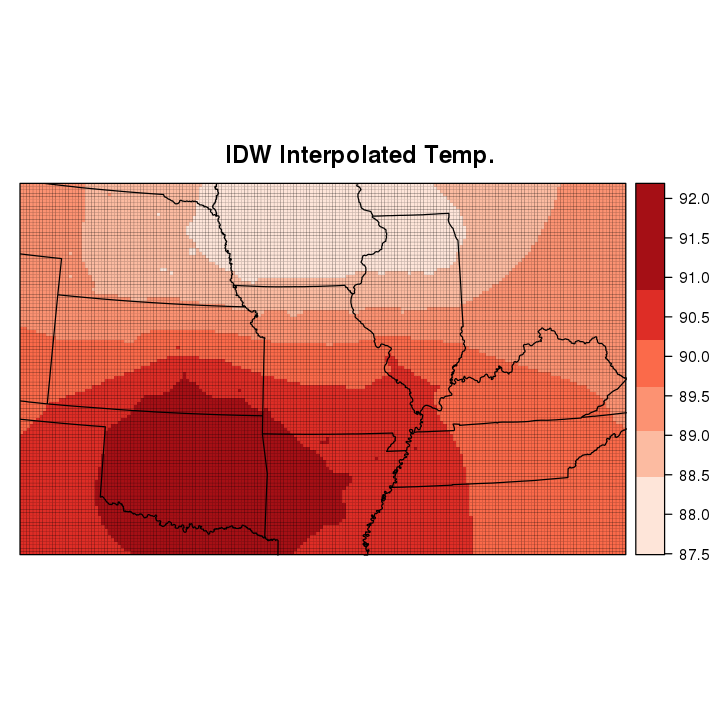

In [42]:
#classify the predicted data values and assign a color schema
numcat <- 6
cate <- classIntervals(rvals, numcat, style = "kmeans")
color.pal <- brewer.pal(numcat, "Reds")

# Visualize the idw prediction surface
spplot(temidw1["var1.pred"], 
           col.regions = color.pal,at=cate$brks,main="IDW Interpolated Temp.",
           panel = function(...) {
                     panel.gridplot(..., border="black")
                     sp.polygons(inFeature.polys.UTM)
           })

### IDW - Interpolation at Each Cell Involves a Restricted Set of Observed Data Points

Next, consider the case where interpolation at a location (cell) involves only observed values at the 1 to 5 closest neighbors. Again, the 'nmin' and 'nmax' parameters allow these values to be customized.  Experiment with the idp parameter and note the effects of its increase/decrease. Experiment with nmin/nmax and note the impact of changing these parameters.

[inverse distance weighted interpolation]


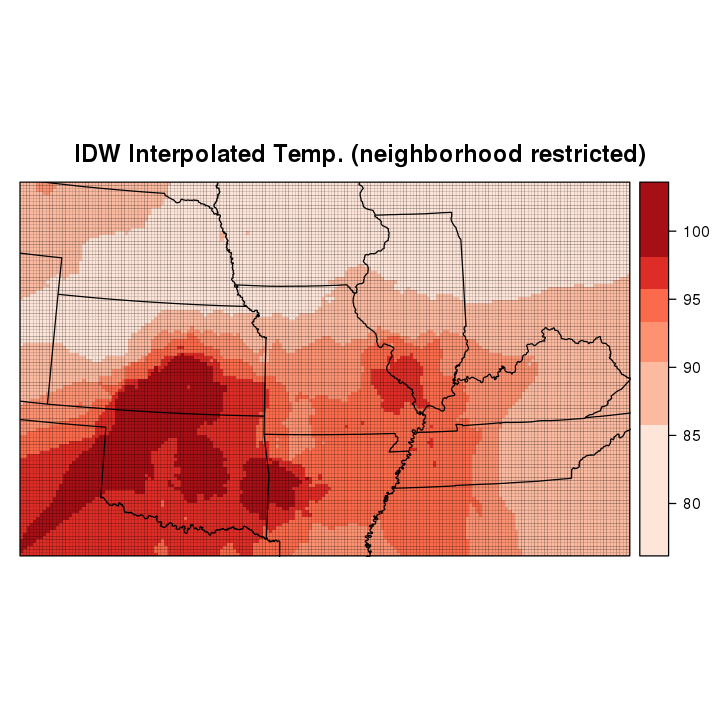

In [43]:
# implement local idw (up to 10 nearest observations)
temidw2 <- idw(formula = inVa ~ 1, locations = inFeature.pts, newdata=grd, nmin = 1, nmax = 5, idp=.5)

#retrieve the interpolated files from the gridded spatialpixels dataframe
rvals2 <- temidw2@data$var1.pred

#classify the predicted data values and assign a color schema
numcat <- 6
cate <- classIntervals(rvals2, numcat, style="kmeans")
color.pal <- brewer.pal(numcat,"Reds")

# Visualize the idw prediction surface
spplot(temidw2["var1.pred"], 
           col.regions= color.pal,at=cate$brks,
           main = "IDW Interpolated Temp. (neighborhood restricted)",
           panel = function(...) {
                panel.gridplot(..., border="black")
                sp.polygons(inFeature.polys.UTM)
           })